In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_extra = pd.read_csv('data/training_extra.csv')
sample = pd.read_csv('data/sample_submission.csv')

# сохраняю id
test_id = test['id']

# EDA

### Признаки: 'Brand', 'Material', 'Size', 'Style', 'Color'
- Категориальные с равномерным распределением
- Делаю новые признаки по категориям (Nan значение отдельный признак)
- drop_first=True -
- drop_first=False - 

### Признаки: 'Laptop Compartment', 'Waterproof'
- Категориальные, бинарные с равномерным распределением
- Делаю новые признаки по категориям (Nan значение отдельный признак) drop_first=True

### Признак 'Weight Capacity (kg)'
- в train nan удаляю строки
- в test заменяю на среднее значение

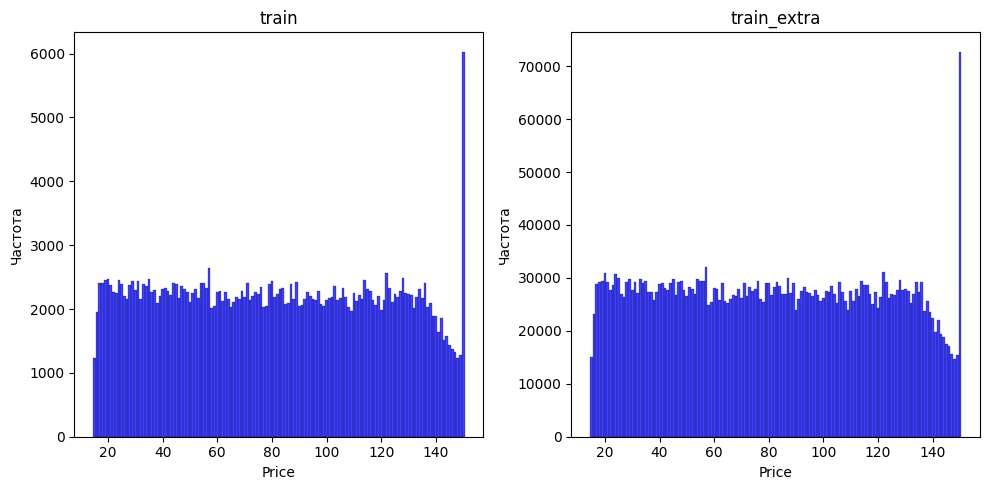

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, value in enumerate([train['Price'], train_extra['Price']]):
    sns.histplot(value, color='blue', ax=axes[i], discrete=True)
    axes[i].set_title(('train', 'train_extra')[i != 0])
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

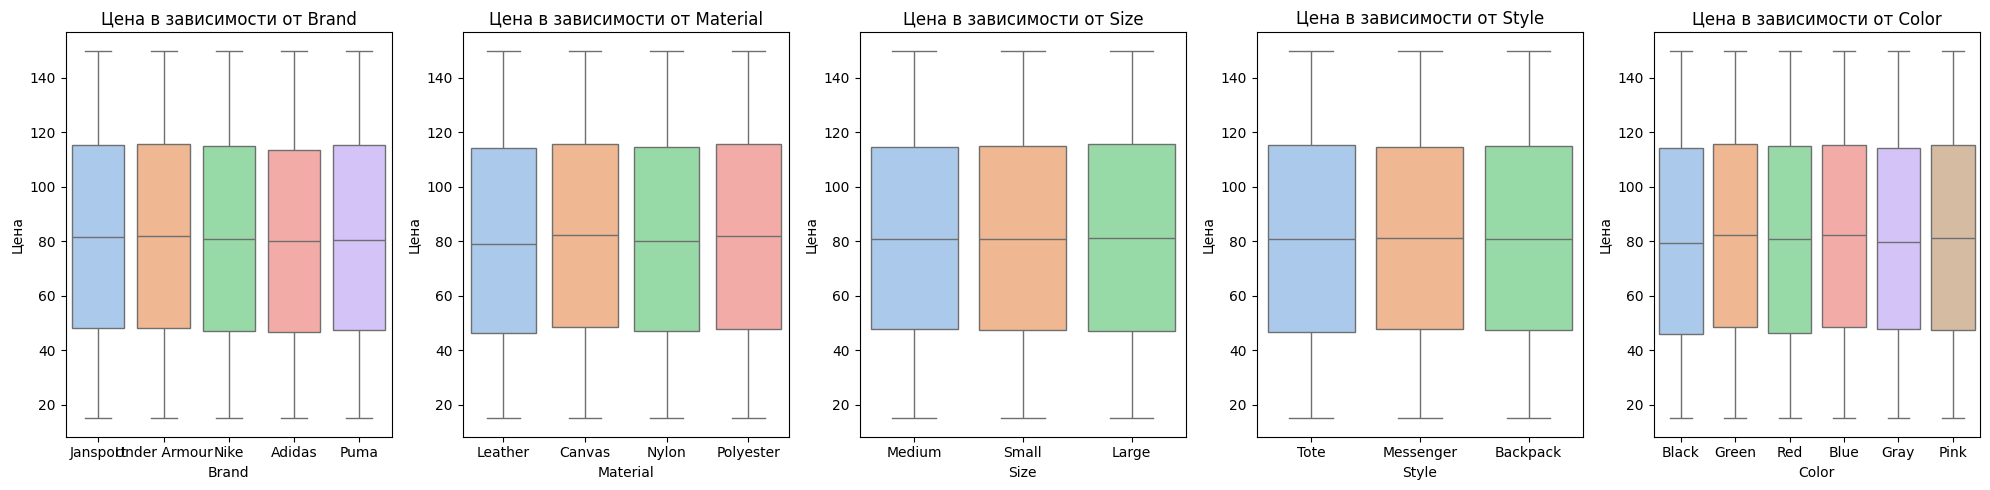

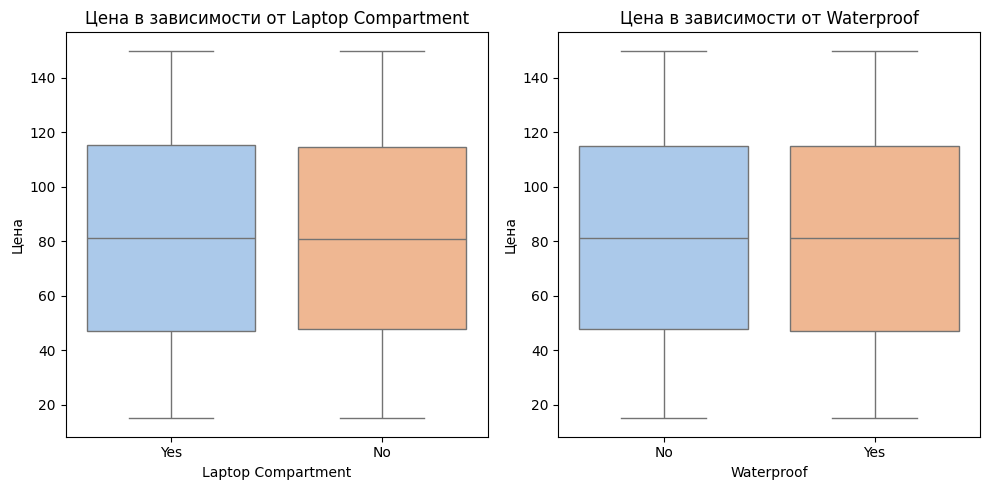

In [4]:
multi_class_features = ['Brand', 'Material', 'Size', 'Style', 'Color']
binary_features = ['Laptop Compartment', 'Waterproof']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i, column in enumerate(multi_class_features):
    sns.boxplot(data=train, x=column, y='Price', hue=column, palette='pastel', ax=axes[i], legend=False)
    axes[i].set_title(f'Цена в зависимости от {column}')
    axes[i].set_ylabel('Цена')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, column in enumerate(binary_features):
    sns.boxplot(data=train, x=column, y='Price', hue=column, palette='pastel', ax=axes[i], legend=False)
    axes[i].set_title(f'Цена в зависимости от {column}')
    axes[i].set_ylabel('Цена')

plt.tight_layout()
plt.show()

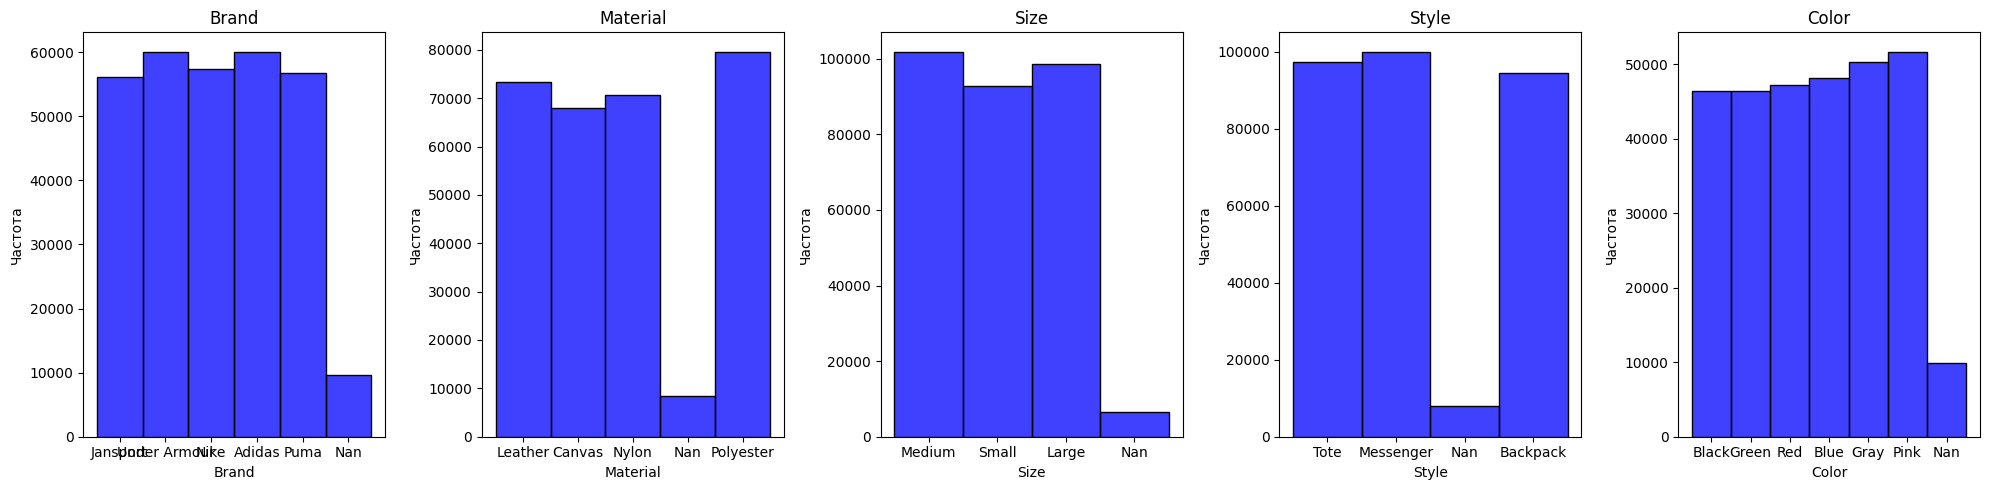

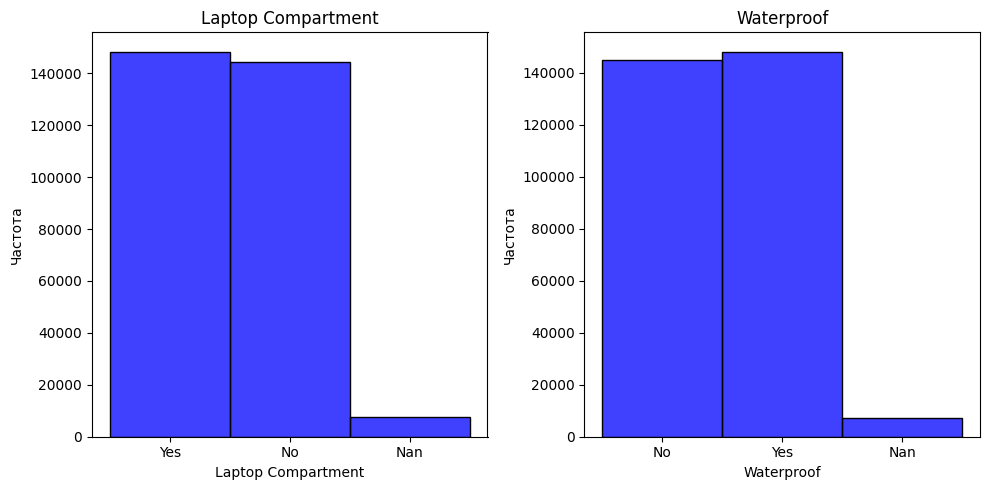

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i, column in enumerate(multi_class_features):
    sns.histplot(train[column].fillna('Nan'), bins=20, color='blue', ax=axes[i], discrete=True)
    axes[i].set_title(column)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, column in enumerate(binary_features):
    sns.histplot(train[column].fillna('Nan'), bins=20, color='blue', ax=axes[i], discrete=True)
    axes[i].set_title(column)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# cat validation

In [3]:
class_features = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment', 'Waterproof']

def cat_category(df):
    df[class_features] = df[class_features].fillna('Unknown')
    df[class_features] = df[class_features].astype('category')
    return df
    

train = cat_category(train)
test = cat_category(test)
train_extra = cat_category(train_extra)

In [4]:
train = train.dropna(subset=['Weight Capacity (kg)'])
test['Weight Capacity (kg)'] = test['Weight Capacity (kg)'].fillna(test['Weight Capacity (kg)'].mean())
train_extra = train_extra.dropna(subset=['Weight Capacity (kg)'])


def cat_weight(df):
    conditions = [
        (df["Weight Capacity (kg)"] <= 5),
        (df["Weight Capacity (kg)"]  > 5) & (df["Weight Capacity (kg)"] <= 15),
        (df["Weight Capacity (kg)"]  > 15) & (df["Weight Capacity (kg)"] <= 20),
        (df["Weight Capacity (kg)"]  > 20) & (df["Weight Capacity (kg)"] <= 25),
        (df["Weight Capacity (kg)"] > 25)]
    
    choices = ['Light', 'Middle', 'Light_heavy', 'Middel_heavy','Heavy']
    
    df['Weight_Class'] = np.select(conditions, choices, default='')
    df['Weight_Class'] = df['Weight_Class'].astype("category")
    
    return df


train = cat_weight(train)
test = cat_weight(test)
train_extra = cat_weight(train_extra)

In [5]:
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
train_extra.drop(columns='id', inplace=True)

In [ ]:
# train = pd.concat([train, train_extra], ignore_index=True)

In [6]:
X = train.drop(columns='Price')
y = train['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [8]:
params = {'random_seed': 42,
          'verbose': 0,
          'eval_metric': 'RMSE',
          'objective': 'RMSE',
          'cat_features': list(X.columns[X.dtypes == 'category'])}

In [9]:
cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
pred = cat_model.predict(test)
rmse

39.005752880217386

In [11]:
output = pd.DataFrame({'id': test_id, 'Price': pred})
output.to_csv('data/cat_model.csv', index=False)

# full validation

In [3]:
train = train.dropna(subset=['Weight Capacity (kg)'])
test['Weight Capacity (kg)'] = test['Weight Capacity (kg)'].fillna(test['Weight Capacity (kg)'].mean())
train_extra = train_extra.dropna(subset=['Weight Capacity (kg)'])

In [4]:
def weight_split(df):
    df['Light'] = (df["Weight Capacity (kg)"] <= 5).astype(int)
    df['Middle'] = ((df["Weight Capacity (kg)"] > 5) & (train["Weight Capacity (kg)"] <= 15)).astype(int)
    df['Light_heavy'] = ((df["Weight Capacity (kg)"] > 15) & (train["Weight Capacity (kg)"] <= 20)).astype(int)
    df['Middle_heavy'] = ((df["Weight Capacity (kg)"] > 20) & (train["Weight Capacity (kg)"] <= 25)).astype(int)
    df['Heavy'] = (df["Weight Capacity (kg)"] > 25).astype(int)
    return df


train = weight_split(train)
test = weight_split(test)
train_extra = weight_split(train_extra)

In [5]:
class_features = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment', 'Waterproof']


def cat_category(df):
    df = pd.get_dummies(df, columns=class_features, dtype='int', dummy_na=True, drop_first=True)
    return df
    

train = cat_category(train)
test = cat_category(test)
train_extra = cat_category(train_extra)

In [6]:
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)

train_extra.drop(columns='id', inplace=True)

In [ ]:
# train = pd.concat([train, train_extra], ignore_index=True)

In [8]:
X = train.drop(columns='Price')
y = train['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
lgbmr_model = LGBMRegressor()
lgbmr_model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred = lgbmr_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
pred = lgbmr_model.predict(test)
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 239889, number of used features: 32
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 81.471898


38.94346799157784

In [ ]:
output = pd.DataFrame({'id': test_id, 'Price': pred})
output.to_csv('data/lgbm_model.csv', index=False)